In [1]:
import math
import time
import numbers
import numpy as np
from PIL import Image
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from ipywidgets import FloatSlider, IntSlider, Dropdown, Layout, interact

from lib.util import plot_XY_function_graph
from lib.cnn import ImageUtil, CNN, CNNTemplate, CNNSimulator
from lib.cnn_template import CNNTemplateLib
from lib.ode import rk4_system_algorithm, rk4_system_method, rkacem_system_method, ode_methods

## Implementation of ImageUtil

In [2]:
# todo read the doc https://towardsdatascience.com/how-to-speedup-data-processing-with-numpy-vectorization-12acac71cfca

We dont know the exact equation of CNN but we know the differential equation of the CNN.

> Dynamic equation of is not depends on time i.e there is no term of $t$ its only depends on neighbor cell values

In the next cell we visualize the dynamic of a cnn for a hole filling problem.

We will fill hole of a two dimensional bipolar($\pm1$) image.

If we take 0 indexed array then 
$A(i,j;k,l) = A(k-i+1, l-j+1)$

If we take 1 indexed array then 
$A(i,j;k,l) = A(k-i+2, l-j+2)$

it controll feedback from neighbors

## Notes on encoding image

Its depends on what was the asumption when we design our template for a speficic problem

for the problem of hole fill with template 

$$
A=
\begin{bmatrix} 
    0 & 0.6 & 0 \\
    0.6 & 4 & 0.6 \\
    0 & 0.6 & 0 \\
\end{bmatrix}
B=
\begin{bmatrix} 
    0 & 0 & 0 \\
    0 & 4 & 0 \\
    0 & 0 & 0 \\
\end{bmatrix}
I = -1
$$

Assumption on on $R_x=1$ and $C=1$.

We consider $+1$ stand for the **black** pixel and $-1$ for the **white** one.

## A simulation example

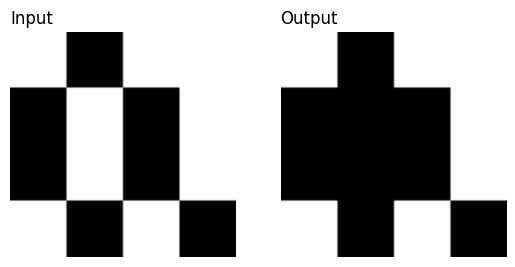

In [3]:
# In the np_array encoding 0 stands for black 
# and 255 stands for white pixel.
input_image_array = np.array(
[[255, 0, 255, 255],
[0, 255, 0, 255],
[0, 255, 0, 255],
[255, 0, 255, 0]]
,dtype=np.uint8)

output_image_array = np.array(
[[255, 0, 255, 255],
[0, 0, 0, 255],
[0, 0, 0, 255],
[255, 0, 255, 0]]
,dtype=np.uint8)

input_image = ImageUtil.image_from_gray_encode_nparray(input_image_array, scale=20)
output_image = ImageUtil.image_from_gray_encode_nparray(output_image_array, scale=20)

f, axarr = plt.subplots(1,2)

axarr[0].axis('off')
axarr[1].axis('off')
axarr[0].set_title('Input', fontsize='large', loc='left')
axarr[1].set_title('Output', fontsize='large', loc='left')
axarr[0].imshow(input_image, cmap = plt.cm.gray)
axarr[1].imshow(output_image, cmap = plt.cm.gray)


## First implementation of CNN simulation

In [4]:
# First implementation of CNN simulation
cnn_state = np.array(
[[+1, +1, +1, +1],
[+1, +1, +1, +1],
[+1, +1, +1, +1],
[+1, +1, +1, +1],]
)
    
def calculate_cnn_dynamic(i, j, cnn_state):
    # print(f"Calculating dynamic for (i, j)=({i}, {j})")
    cnn_input = np.array(
    [[-1, +1, -1, -1],
    [+1, -1, +1, -1],
    [+1, -1, +1, -1],
    [-1, +1, -1, +1],]
    )

    A = np.array(
    [[0, 0.6, 0],
    [0.6, 4, 0.6],
    [0, 0.6, 0]]
    )
    B = np.array(
    [[0, 0, 0],
    [0, 4, 0],
    [0, 0, 0]]
    )
    I = -1
    
    Vx = cnn_state
    Vu = cnn_input
    C = 1
    Rx = 1
    
    
    # print("Given, ")
    # print("Vx =", Vx)
    # print("Vu =", Vu)
    
    x_sum = -(1/Rx)*Vx[i,j]
    x_sum_str = f"-(1/Rx)*Vx[{i},{j}]"
    
    y_sum = 0
    y_sum_str = ""
    
    u_sum = 0
    u_sum_str = ""

    for k in range(i-1,i+2):
        for l in range(j-1,j+2):
            if 0 <= k and k < Vx.shape[0]:
                if 0 <= l and l < Vx.shape[1]:
                    Vy = (abs(Vx[k,l]+1) - abs(Vx[k,l]-1))/2
                    Vy_str = f"+(abs(Vx[{k},{l}]+1) - abs(Vx[{k},{l}]-1))/2"
                    
                    y_sum = y_sum + A[k-i+1, l-j+1]*Vy
                    y_sum_str = y_sum_str + f" + A[{k-i+1}, {l-j+1}]*Vy[{k}, {l}]"
                    # y_sum_str = y_sum_str + f"A[{k-i+1}, {k-i+1}]*{Vy_str}"
                    
                    u_sum = u_sum + B[k-i+1, l-j+1]*Vu[k,l]
                    u_sum_str = u_sum_str + f" + B[{k-i+1}, {k-i+1}]*Vu[{k},{l}]"
    dynamic = x_sum + y_sum + u_sum + I
    dynamic_str = f"{x_sum_str}{y_sum_str}{u_sum_str}"
    # print("Eval = ", dynamic_str)
    return dynamic

def calculate_dynamic(state):
    dynamics = np.zeros((4, 4))
    for i in range(0, 4):
        for j in range(0, 4):
            dynamics[i, j] = calculate_cnn_dynamic(i, j, state)
    return dynamics

total_row_num = 4
total_col_num = 4
def get_dynm_fun_at(index):
    i = index // total_col_num
    j = index % total_col_num
    return lambda t, X : calculate_cnn_dynamic(i, j, X.reshape(total_row_num, total_col_num))

@widgets.interact(sumulation_time=(0, 3, .1), step_size=(.1, 2, .1))
def simulate(sumulation_time, step_size):
    cnn_1d_state = cnn_state.reshape((total_col_num*total_row_num))
    T, XX = rk4_system_algorithm(t0=0, X0=cnn_1d_state, tn=sumulation_time, h=step_size, getFunc=get_dynm_fun_at, ode_method=rkacem_system_method, tol=.01, max_tolerable_dynamic=.01)
    result = XX[-1].reshape((4,4))
    vy = (abs(result+1) - abs(result-1))/2
    print(T)
    display(ImageUtil.image_from_bipolar_encode_nparray(vy, scale=50))
    print("state =\n", result)
    dynm = calculate_dynamic(result)
    print("dynamic =\n", dynm)
    print("max dynamic =", np.max(abs(dynm)))
    # print(np.max(dynm))

interactive(children=(FloatSlider(value=1.0, description='sumulation_time', max=3.0), FloatSlider(value=1.0, d…

## Refactored implementation of CNN simulator

In [6]:
# simulate simple holefill to test refactor implementation
def simulate_hole_fill():
        
    hole_fill_template = CNNTemplate(
        A=np.array(
            [[0, 0.6, 0],
            [0.6, 4, 0.6],
            [0, 0.6, 0]]
        ),
        B=np.array(
            [[0, 0, 0],
            [0, 4, 0],
            [0, 0, 0]]
        ),
        I=-1
    )

    cnn_state = np.array(
        [[+1, +1, +1, +1],
        [+1, +1, +1, +1],
        [+1, +1, +1, +1],
        [+1, +1, +1, +1],]
    )

    cnn_input = np.array(
        [[-1, +1, -1, -1],
        [+1, -1, +1, -1],
        [+1, -1, +1, -1],
        [-1, +1, -1, +1],]
    )

    cnn = CNN(cnn_input, cnn_state, hole_fill_template)
    simulator = CNNSimulator(cnn)
    simulator.ode_method = rkacem_system_method
    # simulator.ode_method = rk4_system_method
    simulator.step_size = 1
    simulator.simulation_time = 20
    simulator.simulate()
    simulator.display_simulator_output()

simulate_hole_fill()

computation time = 0.04129910469055176
simulation time = 19.210784019691157
total iteration = 11
system max_dynamic =  0.08315851761158477
